In [166]:
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [167]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [168]:
# Загрузка и предобработка данных
df = pd.read_csv('tesla_tweets.csv')  # Замените 'tesla_tweets.csv' на имя вашего файла с данными
tweets = df['text'].values
k_values = df['k'].values

In [169]:
# Предобработка текстов
stop_words = set(stopwords.words('english'))  # Предполагается, что тексты на английском
lemmatizer = WordNetLemmatizer()

In [170]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return ' '.join(lemmatized_tokens)

In [171]:
preprocessed_tweets = [preprocess_text(tweet) for tweet in tweets]

In [172]:
# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(preprocessed_tweets, k_values, test_size=0.2, random_state=42)

In [173]:
# Создание Bag of Words представления текста
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [174]:
# # Обучение модели LSTM
# max_sequence_length = 100  # Максимальная длина последовательности
# X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
# X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

# model = Sequential()
# model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length))
# model.add(LSTM(64))
# model.add(Dense(1, activation='swish'))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train_padded, y_train, epochs=10, batch_size=8, validation_data=(X_test_padded, y_test))

Epoch 1/10
62/62 [==============================] - 8s 75ms/step - loss: 0.1050 - val_loss: 0.0011
Epoch 2/10
62/62 [==============================] - 5s 76ms/step - loss: 0.0026 - val_loss: 7.0532e-04
Epoch 3/10
62/62 [==============================] - 4s 64ms/step - loss: 0.0016 - val_loss: 8.0357e-04
Epoch 4/10
62/62 [==============================] - 3s 53ms/step - loss: 9.8304e-04 - val_loss: 7.7759e-04
Epoch 5/10
62/62 [==============================] - 3s 42ms/step - loss: 7.3810e-04 - val_loss: 8.6221e-04
Epoch 6/10
62/62 [==============================] - 4s 58ms/step - loss: 6.1729e-04 - val_loss: 8.0727e-04
Epoch 7/10
62/62 [==============================] - 4s 62ms/step - loss: 7.2713e-04 - val_loss: 0.0015
Epoch 8/10
62/62 [==============================] - 4s 59ms/step - loss: 7.9416e-04 - val_loss: 6.9841e-04
Epoch 9/10
62/62 [==============================] - 4s 64ms/step - loss: 6.3166e-04 - val_loss: 8.8278e-04
Epoch 10/10
62/62 [==============================] - 3s 5

In [179]:
# Создание модели
max_sequence_length = 100  # Максимальная длина последовательности
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')


model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=100))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))

# Создание входа для данных о ценах акций
input_prices = Input(shape=(1,))

# Комбинирование текстовых и ценовых данных
combined_input = Concatenate()([model.output, input_prices])  # Замените на вашу обработку данных о ценах акций
output = Dense(2)(combined_input)

final_model = Model(inputs=[model.input, input_prices], outputs=output)

def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Компиляция модели
final_model.compile(loss=r_squared, optimizer='adam')

# Обучение модели
final_model.fit([X_train_padded, y_train], y_train, epochs=10, batch_size=8, validation_data=([X_test_padded, y_test], y_test))

Epoch 1/10
62/62 [==============================] - 16s 159ms/step - loss: -699486.5625 - val_loss: -1884861.7500
Epoch 2/10
62/62 [==============================] - 6s 103ms/step - loss: -5667818.0000 - val_loss: -2726740.2500
Epoch 3/10
62/62 [==============================] - 6s 97ms/step - loss: -2043179.0000 - val_loss: -3033421.2500
Epoch 4/10
62/62 [==============================] - 7s 111ms/step - loss: -2214523.5000 - val_loss: -3391658.0000
Epoch 5/10
62/62 [==============================] - 6s 90ms/step - loss: -2641530.0000 - val_loss: -3860460.5000
Epoch 6/10
62/62 [==============================] - 5s 88ms/step - loss: -2719990.2500 - val_loss: -4369795.5000
Epoch 7/10
62/62 [==============================] - 5s 82ms/step - loss: -6963343.0000 - val_loss: -5525634.0000
Epoch 8/10
62/62 [==============================] - 6s 100ms/step - loss: -20900562.0000 - val_loss: -7315046.0000
Epoch 9/10
62/62 [==============================] - 7s 115ms/step - loss: -7709414.0000 - v

In [180]:
y_pred = model.predict(X_test_padded).flatten()

4/4 [==============================] - 2s 57ms/step


In [181]:
# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Коэффициент детерминации (R-squared): {r_squared}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 21.915420235166668
Mean Squared Error (MSE): 480.28631122174414
Root Mean Squared Error (RMSE): 21.915435455900578
Коэффициент детерминации (R-squared): -719919.7079514031
Mean Absolute Percentage Error (MAPE): 2187.947162276448%


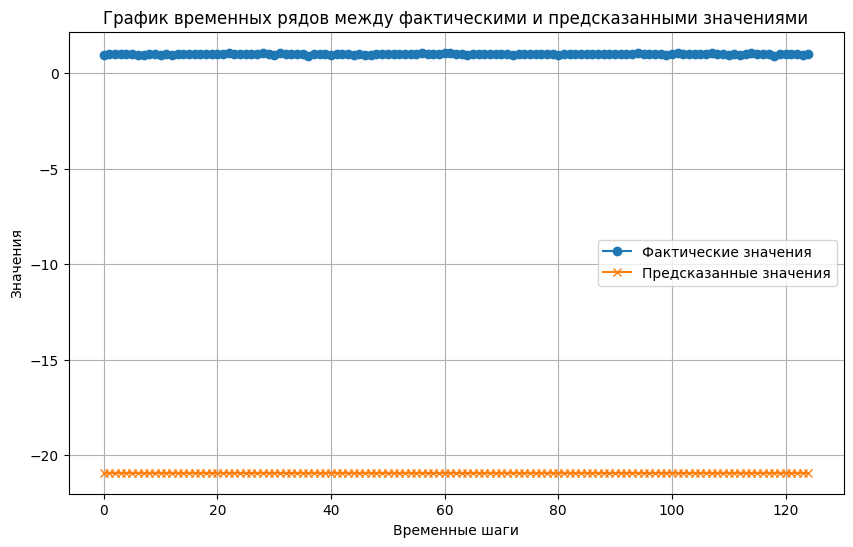

In [182]:
time_steps = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(time_steps, y_test, label='Фактические значения', marker='o')
plt.plot(time_steps, y_pred, label='Предсказанные значения', marker='x')
plt.xlabel('Временные шаги')
plt.ylabel('Значения')
plt.title('График временных рядов между фактическими и предсказанными значениями')
plt.legend()
plt.grid(True)

In [183]:
y_pred

array([-20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913145,
       -20.913145, -20.913145, -20.913145, -20.913145, -20.913

In [146]:
y_pred.shape

(125,)

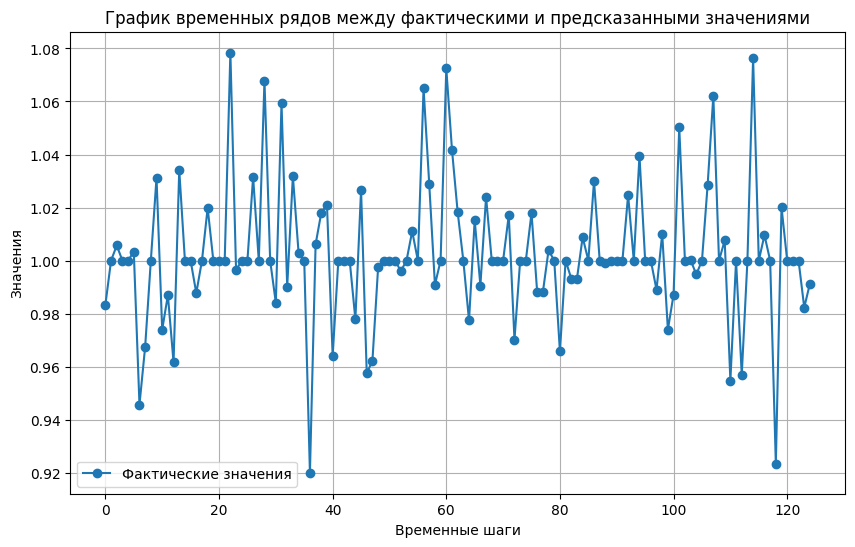

In [184]:
time_steps = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(time_steps, y_test, label='Фактические значения', marker='o')
plt.xlabel('Временные шаги')
plt.ylabel('Значения')
plt.title('График временных рядов между фактическими и предсказанными значениями')
plt.legend()
plt.grid(True)

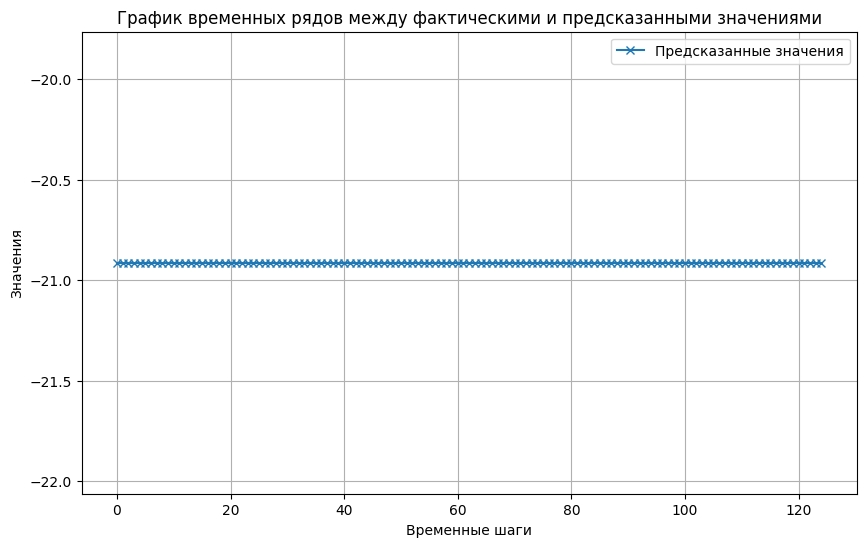

In [185]:
time_steps = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(time_steps, y_pred, label='Предсказанные значения', marker='x')
plt.xlabel('Временные шаги')
plt.ylabel('Значения')
plt.title('График временных рядов между фактическими и предсказанными значениями')
plt.legend()
plt.grid(True)

In [28]:
# Прогноз изменения цены акций на основе текста
new_tweet = ["Tesla announces a breakthrough in battery technology."]
new_tweet_preprocessed = [preprocess_text(tweet) for tweet in new_tweet]
new_tweet_sequences = tokenizer.texts_to_sequences(new_tweet_preprocessed)
new_tweet_padded = pad_sequences(new_tweet_sequences, maxlen=max_sequence_length, padding='post')
predicted_k = model.predict(new_tweet_padded)
print(f'Predicted coefficient (k) for the new tweet: {predicted_k[0][0]}')

1/1 [==============================] - 0s 446ms/step
Predicted coefficient (k) for the new tweet: 1.002305269241333


In [29]:
df

,text,k
0,No tweet,1.156913
1,No tweet,0.946393
2,No tweet,0.898637
3,No tweet,0.855687
4,No tweet,0.891720
...,...,...
3674,Q3 2023 Earnings Call https://t.co/eSwixzYTJD,1.000000
3675,Q3 2023 Earnings Call https://t.co/eSwixzYTJD,0.900440
3676,No tweet,0.961754
3677,No tweet,0.983869
